## Exp 2: a simple classifier with the barcode dataset
### The training data is less than 10 classes
The output layer is a classifier layer (one hot encoding)

In [1]:
from __future__ import print_function
from __future__ import absolute_import
import matplotlib.pyplot as plt

import sugartensor as tf
import os
from IPython.display import display, Image
import numpy as np
from scipy import ndimage
from six.moves import cPickle as pickle

import os
os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID"   # see issue #152
os.environ["CUDA_VISIBLE_DEVICES"]="3"
%matplotlib inline


In [2]:
batch_size = 64   # batch size
image_size = 32
pixel_depth = 255.0

## Training data

In [3]:
dir= "barcode/train/"
fn = os.listdir(dir)
total = len(fn)
total
#     change the range to switch between exp2 : [0, 1, 2, 3, 4, 5, 6]
#     and exp2.1: [1, 3, 5, 7, 9]
visible = [1,3,5,7,9]
# put all the images into this blob of size total*size*size*1
# REMEMBER to change shape of dataset
training_dataset = np.ndarray(shape = (3000*len(visible), image_size, image_size, 1), dtype = np.float32)
counter = 0
# REMEMBER to change shape of training label
training_label = np.ndarray(shape = (3000*len(visible)), dtype = np.int64)
for file in fn:
    image_data = (ndimage.imread(dir+file).astype(float) - 
                    pixel_depth / 2) / pixel_depth

    if int(file[0]) in visible:
        training_label[counter] = int(file[0])
        training_dataset[counter, :, :] = image_data[:,:,0].reshape(image_size, image_size, 1)
        counter+=1
print(len(training_label))
training_image, training_label = tf.sg_data._data_to_tensor([training_dataset, training_label], batch_size, name = "train")
print(training_label)
print(training_image)
print(counter)

15000
Tensor("train_1:1", shape=(64,), dtype=int64)
Tensor("train_1:0", shape=(64, 32, 32, 1), dtype=float32)
15000


## Validation data

3000
[8 1 7 1]
Tensor("train_3:1", shape=(64,), dtype=int64)
Tensor("train_3:0", shape=(64, 32, 32, 1), dtype=float32)


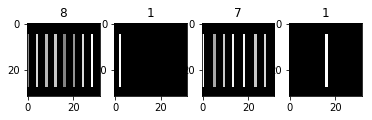

In [4]:
dir= "barcode/valid/"
fn = os.listdir(dir)
total = len(fn)
total
valid_label = np.ndarray(shape = (total), dtype = np.int64)
valid_dataset = np.ndarray(shape = (total, image_size, image_size, 1), dtype = np.float32)
counter = 0
for file in fn:
    image_data = (ndimage.imread(dir+file).astype(float) - 
                    pixel_depth / 2) / pixel_depth
    if True:
        valid_label[counter] = int(file[0])
        valid_dataset[counter, :, :] = image_data[:,:,0].reshape(image_size, image_size, 1)
        counter+=1
print(len(valid_label))

_, axs = plt.subplots(1, 4)

label = valid_label[:4]
image = valid_dataset[:4]
print(label)
for i in range(4):
    axs[i].imshow(image[i].reshape(image_size, image_size), cmap=plt.cm.Greys);
    axs[i].set_title(label[i])

valid_image, valid_label = tf.sg_data._data_to_tensor([valid_dataset, valid_label], batch_size, name = "train")

print(valid_label)
print(valid_image)

In [5]:
# input images and label
x = training_image
y = training_label

with tf.sg_context(name='discriminator', size=4, stride=2, act='leaky_relu'):
        
        # shared part
        # have to set batch norm at the layer level because we dont want to use batch norm everywhere
        logit = (x
                  .sg_conv(dim=64, name = 'conv2', bn = True)
                  .sg_conv(dim=128, name='conv3', bn = True)
                  .sg_flatten()
                  .sg_dense(dim=1024, name='fc1')
                  .sg_dense(dim=10, act='linear', name = 'cat'))

In [6]:
print(logit)
print(y)
loss = logit.sg_ce(target = y, name = 'disc_loss')
# limit gpu
gpu_options = tf.GPUOptions(per_process_gpu_memory_fraction=0.8)

sess = tf.InteractiveSession(config=tf.ConfigProto(gpu_options=gpu_options))
#
# training
#
# accuracy evaluation
acc = (logit.sg_reuse(input = valid_image).sg_softmax()
       .sg_accuracy(target=valid_label, name='val'))
# do training
dir= "barcode/train/"
fn = os.listdir(dir)
total = len(fn)

tf.sg_train(sess = sess, loss = loss, eval_metric=[acc], log_interval=10, max_ep=600, ep_size=total//batch_size, early_stop=False, save_dir='asset/train/exp2.1-classifier')

Tensor("discriminator/cat/out:0", shape=(64, 10), dtype=float32)
Tensor("train_1:1", shape=(64,), dtype=int64)
INFO:tensorflow:Restoring parameters from asset/train/exp2.1-classifier/model.ckpt-0


train:   0%|                                   | 0/468 [00:00<?, ?b/s]

INFO:tensorflow:global_step/sec: 0


train:  72%|█████████████████▉       | 335/468 [00:09<00:02, 44.71b/s]

INFO:tensorflow:global_step/sec: 34.4425


train:  65%|████████████████▏        | 304/468 [00:07<00:03, 41.34b/s]

INFO:tensorflow:global_step/sec: 43.4001


train:  55%|█████████████▊           | 259/468 [00:06<00:04, 42.24b/s]

INFO:tensorflow:global_step/sec: 42.2999


train:  45%|███████████▎             | 212/468 [00:04<00:05, 43.33b/s]

INFO:tensorflow:global_step/sec: 42.4999


train:  14%|███▌                      | 65/468 [00:03<00:44,  9.16b/s]

INFO:tensorflow:global_step/sec: 31.6995


train:  66%|████████████████▌        | 309/468 [00:13<00:03, 44.65b/s]

INFO:tensorflow:global_step/sec: 24.3996


train:  61%|███████████████▏         | 285/468 [00:06<00:04, 43.37b/s]

INFO:tensorflow:global_step/sec: 44.4001


train:  53%|█████████████▎           | 250/468 [00:05<00:05, 43.13b/s]

INFO:tensorflow:global_step/sec: 43.6016


train:  43%|██████████▊              | 202/468 [00:04<00:06, 42.77b/s]

INFO:tensorflow:global_step/sec: 42.0999


train:  28%|███████                  | 133/468 [00:03<00:07, 44.47b/s]

KeyboardInterrupt: 